# EE359-Coursework 4  Streaming Algorithm
Existing codes in this file are just hints. You can modify these codes as you want

## **Task1：DGIM**

DGIM is an efficient algorithm in processing large streams. When it's infeasible to store the flowing binary stream, DGIM can estimate the number of 1-bits in the window. In this coding, you're given the stream_data_dgim.txt (binary stream), and you need to implement the DGIM algorithm to count the number of 1-bits. Write code below.

### 1. Set the window size to 1000, and count the number of 1-bits in the current window.

In [73]:
from collections import defaultdict, deque
from math import ceil
import time

class DGIM:
    def __init__(self, filepath, windowsize=1000, maxtime=None):
        self.filepath = filepath
        self.fileHandler = open(filepath, 'r')
        self.windowSize = windowsize
        self.buckets = deque()
        self.timeMod = maxtime if maxtime else windowsize << 2
        self.timestamp = 0

    def run(self):
        with open(self.filepath, 'r') as f:
            stream = list(map(int, f.read().split()))
        for bit in stream:
            self.update(bit)

    def update(self, bit):
        self.timestamp += 1
        self.remove_old_buckets()

        if bit == 0:
            return
        
        self.buckets.append({'timestamp':self.timestamp, 'size':1})
        i = self.update_index()

        while i is not None:
            self.buckets[i - 1]['size'] += self.buckets[i - 2]['size']
            del self.buckets[i - 2]
            i = self.update_index()

    def update_index(self):
        if len(self.buckets) <= 2:
            return None

        i = len(self.buckets) - 1
        while i > 1:
            curr_size = self.buckets[i]['size']
            if curr_size == self.buckets[i - 1]['size'] == self.buckets[i - 2]['size']:
                return i
            i -= 1

    def remove_old_buckets(self):
        while self.buckets and self.buckets[0]['timestamp'] <= (self.timestamp - self.windowSize):
            self.buckets.popleft()

    def count(self, size):
        total_size = 0
        last_bucket_size = 0
        i = len(self.buckets) - 1
        while i >= 0 and self.buckets[i]['timestamp'] > self.timestamp - size:
            total_size += self.buckets[i]['size']
            last_bucket_size = self.buckets[i]['size']
            i -= 1
        cnt = total_size - int(last_bucket_size / 2.0)
        return cnt

### 2. With the window size 1000, count the number of 1-bits in the last 500 and 200 bits of the bitstream.

In [74]:
# code here
dgim = DGIM("stream_data_dgim.txt", 1000)

# 运行DGIM算法
dgim.run()

# tot_start_time = time.time()
# for size in  [1000, 500, 200]: #[1000, 500, 200]:
#     start_time = time.time()
#     cnt = dgim.count(size)
#     print(f"Windiw size is {size}")
#     print(f" DGIM count of 1 is {cnt}, counting time cost {time.time() - start_time :.8f}s.")
# print(f'total running time: {time.time() - tot_start_time}s ')
tot_start_time = time.perf_counter()
for size in  [1000, 500, 200]: #[1000, 500, 200]:
    start_time = time.perf_counter()
    cnt = dgim.count(size)
    print(f"Windiw size is {size}")
    print(f" DGIM count of 1 is {cnt}, counting time cost {time.perf_counter() - start_time}s.")
print(f'total running time: {time.perf_counter() - tot_start_time}s ')

Windiw size is 1000
 DGIM count of 1 is 508, counting time cost 0.00013179999950807542s.
Windiw size is 500
 DGIM count of 1 is 220, counting time cost 1.3999999282532372e-05s.
Windiw size is 200
 DGIM count of 1 is 76, counting time cost 1.1400001312722452e-05s.
total running time: 0.00031569999919156544s 


### 3. Write a function that accurately counts the number of 1-bits in the current window. Caculate the accuracy of your own DGIM algorithm and compare the running time difference.

In [76]:
# Your code here, you can add cells if necessary
import numpy as np
import time

def accurateCountTask1():
    with open('stream_data_dgim.txt', 'r') as f:
        stream = list(map(int, f.read().split()))
    return sum(stream[-1000:])
dgim = DGIM('stream_data_dgim.txt', windowsize=1000)
dgim.run()
time1 = time.perf_counter()
dgim.count(1000)
time2 = time.perf_counter()
print("DGIM result:{},\t time cost:{:.15f}s".format(dgim.count(1000), time2 - time1))
time1 = time.perf_counter()
accurateCountTask1()
time2 = time.perf_counter()
print("accurate result:{},\t time cost:{}s".format(accurateCountTask1(),time2-time1))


DGIM result:508,	 time cost:0.000056800001403s
accurate result:391,	 time cost:0.003608400000302936s


## **Task2: Bloom Filter**

A Bloom filter is a space-efficient probabilistic data structure. Here the task is to implement a bloom filter by yourself. 

### Data loading:

From the NLTK (Natural Language ToolKit) library, we import a large list of English dictionary words, commonly used by the very first spell-checking programs in Unix-like operating systems.

In [37]:
import nltk
from nltk.corpus import words
nltk.download('words')
word_list = words.words()

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


Then we load another dataset from the NLTK Corpora collection: movie_reviews.

The movie reviews are categorized between positive and negative, so we construct a list of words (usually called bag of words) for each category.

In [38]:
from nltk.corpus import movie_reviews
nltk.download('movie_reviews')

neg_reviews = []
pos_reviews = []

for fileid in movie_reviews.fileids('neg'):
  neg_reviews.extend(movie_reviews.words(fileid))
for fileid in movie_reviews.fileids('pos'):
  pos_reviews.extend(movie_reviews.words(fileid))

[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


Here we get a data stream (word_list) and 2 query lists (neg_reviews and pos_reviews).

### 1. Write a function that accurately determines whether each word in neg_reviews and pos_reviews belongs to word_list.

In [39]:
import numpy as np
import time

def linear_search(word_list, target_word):
    return target_word in word_list

In [40]:
# Binary search
neg_flag_b = np.zeros(len(neg_reviews), dtype=bool)
pos_flag_b = np.zeros(len(pos_reviews), dtype=bool)
# to store the accurate result

t = time.time()
sorted_word_list = sorted(word_list)
for i, neg_word in enumerate(neg_reviews):
    neg_flag_b[i] = linear_search(sorted_word_list, neg_word)
for i, pos_word in enumerate(pos_reviews):
    pos_flag_b[i] = linear_search(sorted_word_list, pos_word)
print("Search Time:", time.time() - t)

Search Time: 3826.2166328430176


 ### 2. Implement the bloom filter by yourself and add all words in word_list in your bloom filter. Compare the running time difference between exact search (Task2 Question1) and multiple hash computations in a Bloom filter.

In [77]:
import hashlib
import numpy as np
import time
import matplotlib.pyplot as plt

class BloomFilter:
    def __init__(self, m, k):
        self.m = int(m)
        self.k = int(k)
        self.table = np.zeros((self.m), dtype=bool)
        self.hash_func = [hashlib.sha256(), hashlib.md5(), hashlib.sha1(), hashlib.sha224(), hashlib.sha384(), hashlib.sha512()]
    def add(self, item):
        hash1 = hashlib.sha256()
        hash1.update(item.encode())
        hash1 = int(hash1.hexdigest(), 16) % self.m
        hash2 = hashlib.md5()
        hash2.update(item.encode())
        hash2 = int(hash2.hexdigest(), 16) % self.m
        
        for i in range(self.k):
            h = (hash1 + i * hash2) % self.m
            self.table[h] = True
    def check(self, item):
        hash1 = hashlib.sha256()
        hash1.update(item.encode())
        hash1 = int(hash1.hexdigest(), 16) % self.m
        hash2 = hashlib.md5()
        hash2.update(item.encode())
        hash2 = int(hash2.hexdigest(), 16) % self.m
        
        for i in range(self.k):
            h = (hash1 + i * hash2) % self.m
            if not self.table[h]:
                return False
        return True
    # def false_positive_rate(self, n):
    #     fp = 0
    #     for i in range(n):
    #         item = str(i)
    #         if self.check(item):
    #             if i >= self.count:
    #                 fp += 1
    #     return fp / n

In [78]:
bf = BloomFilter(1e7, 4)
neg_bf = np.zeros(len(neg_reviews), dtype=bool)
pos_bf = np.zeros(len(pos_reviews), dtype=bool)
n = neg_bf.shape[0] + pos_bf.shape[0]
t = time.time()
for word in word_list:
    bf.add(word)
for i, neg_word in enumerate(neg_reviews):
    neg_bf[i] = bf.check(neg_word)
for i, pos_word in enumerate(pos_reviews):
    pos_bf[i] = bf.check(pos_word)
print("Bloom Filter Time:", time.time()-t)
print("Accuracy:")
print(f"neg: {(neg_bf == neg_flag_b).sum()} / {neg_bf.shape[0]} = {(neg_bf == neg_flag_b).sum() / neg_bf.shape[0]:.4f}")
print(f"pos: {(pos_bf == pos_flag_b).sum()} / {pos_bf.shape[0]} = {(pos_bf == pos_flag_b).sum() / pos_bf.shape[0]:.4f}")

Bloom Filter Time: 7.620692729949951
Accuracy:
neg: 751255 / 751256 = 1.0000
pos: 832564 / 832564 = 1.0000


### 3. Use different bit array length ‘m’ and number of hash functions ‘k’ to implement the bloom filter algorithm. Then compare the impact of different m and k on the false positive rate.

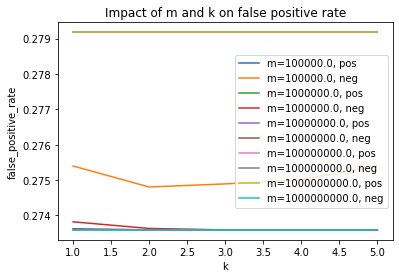

In [82]:
# 构建 Bloom 过滤器
m_values = [1e5,1e6,1e7,1e8,1e9]
# m_values = [1e5,1e6]
k_values = [1, 2, 3, 4, 5]
for m in m_values:
    pos_false_positive_rate = []
    neg_false_positive_rate = []
    for k in k_values:
        bf = BloomFilter(m, k)
        neg_bf = np.zeros(len(neg_reviews), dtype=bool)
        pos_bf = np.zeros(len(pos_reviews), dtype=bool)
        n = neg_bf.shape[0] + pos_bf.shape[0]
        for review in pos_reviews:
            bf.add(review)
        for i, neg_word in enumerate(neg_reviews):
            neg_bf[i] = bf.check(neg_word)
        for i, pos_word in enumerate(pos_reviews):
            pos_bf[i] = bf.check(pos_word)
        pos_cnt = 0
        neg_cnt = 0
        for i in range(neg_bf.shape[0]):
            if neg_bf[i] == neg_flag_b[i]:
                neg_cnt += 1
        for i in range(pos_bf.shape[0]):
            if pos_bf[i] == pos_flag_b[i]:
                pos_cnt += 1
        pos_false_positive_rate.append(1 - pos_cnt / pos_bf.shape[0])
        neg_false_positive_rate.append(1 - neg_cnt / neg_bf.shape[0])
        del bf
    plt.plot(k_values, pos_false_positive_rate, label=f"m={m}, pos")
    plt.plot(k_values, neg_false_positive_rate, label=f"m={m}, neg")
plt.xlabel("k")
plt.ylabel("false_positive_rate")
plt.title("Impact of m and k on false positive rate")
plt.legend()
plt.show()


# for j, m in enumerate(m_values):    
#     for i, k in enumerate(k_values):
#         bf = BloomFilter(m, k)
#         for review in neg_reviews:
#             bf.add(review)
#         for review in pos_reviews:
#             bf.add(review)
#         fp_rate = bf.false_positive_rate(n * 2)
#         fp_rates[i, j] = fp_rate

# # 绘制误判率曲线
# for i, k in enumerate(k_values):
#     plt.plot(k_values, fp_rates[i, :], label=f"k={k}")

# plt.xlabel("m")
# plt.ylabel("false_positive_rate")
# plt.title("Impact of m and k on false positive rate")
# plt.legend()
# plt.show()


## **Task3: Count-Min sketch**



In computing, the count–min sketch (CM sketch) is a probabilistic data structure that serves as a frequency table of events in a stream of data. 

Here we use the query stream (neg_reviews or pos_reviews) from task 2.

### 1. Write a function that accurately counts the occurrence times of each word in neg_reviews or pos_reviews.

In [92]:
# Your code here, you can add cells if necessary
from collections import defaultdict, Counter
def accCount(words):
    # freq = defaultdict(int)
    # for word in words:
    #     freq[word]+=1
    # print(f"Total words: {len(freq)}")
    # return sum(freq.values())
    return Counter(words)
pos_accCount = accCount(pos_reviews)
print("pos_accCount:", len(pos_accCount))


pos_accCount: 30417


### 2. Implement the Count-Min sketch by yourself. Set different width w and depth d of the internal data structure of CM-Sketch. Compare the influence of different w and d on the error.

In [102]:
import hashlib
import numpy as np
import time
import matplotlib.pyplot as plt
import random
# Your code here, you can add cells if necessary
neg_accCount = accCount(neg_reviews)
pos_accCount = accCount(pos_reviews)
print("neg_accCount:", len(neg_accCount))
print("pos_accCount:", len(pos_accCount))
total_count = neg_accCount + pos_accCount

class CountMin:
    def __init__(self, w, d):
        self.w = int(w)
        self.d = int(d)
        self.table=np.zeros((self.d, self.w), dtype=int)
    def add(self, item):
        hash1 = hashlib.sha256()
        hash1.update(item.encode())
        hash1 = int(hash1.hexdigest(), 16) % self.w
        hash2 = hashlib.md5()
        hash2.update(item.encode())
        hash2 = int(hash2.hexdigest(), 16) % self.w
        h = hash1
        for i in range(self.d):
            self.table[i][h] += 1
            h = (h + hash2) % self.w
    def count(self, item):
        hash1 = hashlib.sha256()
        hash1.update(item.encode())
        hash1 = int(hash1.hexdigest(), 16) % self.w
        hash2 = hashlib.md5()
        hash2.update(item.encode())
        hash2 = int(hash2.hexdigest(), 16) % self.w
        h = hash1
        min_cnt = self.table[0][h]
        for i in range(self.d):
            min_cnt = min(min_cnt, self.table[i][h])
            h = (h + hash2) % self.w
        return min_cnt
    
    def add_all(self, words):
        for word in words:
            self.add(word)


# # 测试 Count-Min Sketch 的误差
# w_values = [100, 1000, 10000]
# d_values = [1, 2, 3, 4, 5]
# for w in w_values:
#     for d in d_values:
#         cm = CountMin(w, d)
#         for review in neg_reviews:
#             cm.add(review)
#         for review in pos_reviews:
#             cm.add(review)
#         neg_err = sum([abs(cm.count(word) - neg_reviews.count(word)) for word in neg_reviews]) / neg_accCount
#         pos_err = sum([abs(cm.count(word) - pos_reviews.count(word)) for word in pos_reviews]) / pos_accCount
#         total_err = sum([abs(cm.count(word) - (neg_reviews.count(word) + pos_reviews.count(word))) for word in set(neg_reviews + pos_reviews)]) / total_count
#         print(f"w={w}, d={d}, neg_err={neg_err:.3f}, pos_err={pos_err:.3f}, total_err={total_err:.3f}")

neg_accCount: 28480
pos_accCount: 30417


m = 1e+06, k = 1,
acc: 97.0822 %
mean difference: 0.6376
max difference: 3658 
min difference: 0

m = 1e+06, k = 2,
acc: 99.9192 %
mean difference: 0.0025
max difference: 23 
min difference: 0

m = 1e+06, k = 3,
acc: 100.0000 %
mean difference: 0.0000
max difference: 0 
min difference: 0

m = 1e+06, k = 4,
acc: 100.0000 %
mean difference: 0.0000
max difference: 0 
min difference: 0

m = 1e+06, k = 5,
acc: 100.0000 %
mean difference: 0.0000
max difference: 0 
min difference: 0

m = 1e+07, k = 1,
acc: 99.7402 %
mean difference: 0.0252
max difference: 154 
min difference: 0

m = 1e+07, k = 2,
acc: 100.0000 %
mean difference: 0.0000
max difference: 0 
min difference: 0

m = 1e+07, k = 3,
acc: 100.0000 %
mean difference: 0.0000
max difference: 0 
min difference: 0

m = 1e+07, k = 4,
acc: 100.0000 %
mean difference: 0.0000
max difference: 0 
min difference: 0

m = 1e+07, k = 5,
acc: 100.0000 %
mean difference: 0.0000
max difference: 0 
min difference: 0

m = 1e+08, k = 1,
acc: 99.9789 %
mean

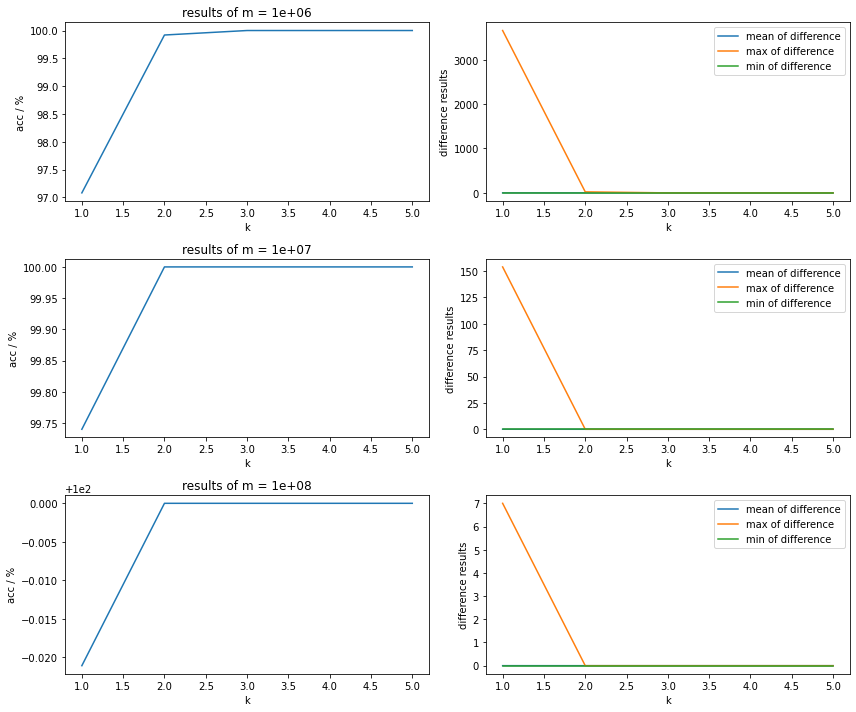

In [103]:
import matplotlib.pyplot as plt

results_list = {}

# Define a list of m values to test
m_values = [int(10**i) for i in range(6, 9)]

fig, axs = plt.subplots(nrows=len(m_values), ncols=2, figsize=(12, 10))

for i, m in enumerate(m_values):
    acc_list, mean_list, max_list, min_list = [], [], [], []

    # Define a list of k values to test
    k_values = [1, 2, 3, 4, 5]

    # for k in k_values:
    #     pred_res = {}
    #     difference = {}
    #     count_min = CountMin(m, k)
    #     count_min.add_all(neg_reviews)

    #     for word in neg_reviews:
    #         word_res = count_min.count(word)   
    #         pred_res[word] = word_res     
    #         difference[word] = abs(word_res - neg_accCount[word])

    #     del count_min  # to save memory

    #     diff_values = np.array(list(difference.values()))
    #     print(f'm = {m:.0e}, k = {k},')
    #     print(f'acc: {100 * np.sum(diff_values == 0) / len(diff_values):.4f} %')
    #     print(f'mean difference: {np.mean(diff_values):.4f}')
    #     print(f'max difference: {np.max(diff_values)} ')
    #     print(f'min difference: {np.min(diff_values)}')
    #     print()

    #     acc_list.append(100 * np.sum(diff_values == 0) / len(diff_values))
    #     mean_list.append(np.mean(diff_values))
    #     max_list.append(np.max(diff_values))
    #     min_list.append(np.min(diff_values))

    for k in k_values:
        count_min = CountMin(m, k)
        count_min.add_all(neg_reviews)

        pred_res = {word: count_min.count(word) for word in neg_reviews}
        difference = {word: abs(pred_res[word] - neg_accCount[word]) for word in neg_reviews}

        del count_min  # to save memory

        diff_values = np.array(list(difference.values()))
        print(f'm = {m:.0e}, k = {k},')
        print(f'acc: {100 * np.sum(diff_values == 0) / len(diff_values):.4f} %')
        print(f'mean difference: {np.mean(diff_values):.4f}')
        print(f'max difference: {np.max(diff_values)} ')
        print(f'min difference: {np.min(diff_values)}')
        print()

        acc_list.append(100 * np.sum(diff_values == 0) / len(diff_values))
        mean_list.append(np.mean(diff_values))
        max_list.append(np.max(diff_values))
        min_list.append(np.min(diff_values))

    results_list[m] = {'acc_list': acc_list, 'mean_list': mean_list, 'max_list': max_list, 'min_list': min_list}

    axs[i, 0].plot(k_values, results_list[m]['acc_list'])
    axs[i, 0].set_title(f"results of m = {m:.0e}")
    axs[i, 0].set_xlabel("k")
    axs[i, 0].set_ylabel("acc / %")

    axs[i, 1].plot(k_values, results_list[m]['mean_list'], label='mean of difference')
    axs[i, 1].plot(k_values, results_list[m]['max_list'], label='max of difference')
    axs[i, 1].plot(k_values, results_list[m]['min_list'], label='min of difference')
    axs[i, 1].set_xlabel("k")
    axs[i, 1].set_ylabel("difference results")
    axs[i, 1].legend()

plt.tight_layout()
plt.show()